<a href="https://colab.research.google.com/github/sfarias03/Education-Inequality/blob/main/SF_Analysis_Education_Inequality.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Introduction

This research project focuses on addressing the issue of educational inequality in American high schools. To gain insights into this issue, data was gathered from EdGap.org and the National Center for Education Statistics. The project specifically looked at the relationship between ACT/SAT exam scores and various socioeconomic factors, such as household income, unemployment rates, and children who benefit from the free/reduced price lunch program. By analyzing this data, the project aimed to gain a deeper understanding of the factors that contribute to unequal educational outcomes in American high schools.

For this purpose of this project SAT scores have been converted to ACT scores.

## Import libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style='whitegrid')
import missingno as msno

from sklearn.linear_model import LinearRegression

from mpl_toolkits.mplot3d import Axes3D

import statsmodels.formula.api as smf
from mpl_toolkits import mplot3d
from matplotlib import cm

from sklearn import linear_model, tree
import statsmodels.api as sm
from sklearn.ensemble import RandomForestRegressor

# Model preprocessing
from sklearn.preprocessing import StandardScaler

# Model metrics and analysis
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from statsmodels.stats.anova import anova_lm

import plotly.offline as pyo
import plotly.graph_objs as go

import itertools as it

## Load clean data

In [ ]:
df_train = pd.read_csv('https://raw.githubusercontent.com/sfarias03/Education-Inequality/main/clean_education_inequality-2.csv')

## State your question

The primary objective is to investigate the relationship between socioeconomic factors and the average ACT performance of schools.

A specific question that we investigate later in this notebook is the relationship between ACT/SAT scores and socioeconomic factors in Washington state compared to Illinois state. Since these two states share similarities in terms of politics, median income, and the number of children who benefit from the free/reduced price lunch program, we were interested in exploring whether their test scores would be comparable or not.

## Pairplot for all Variables

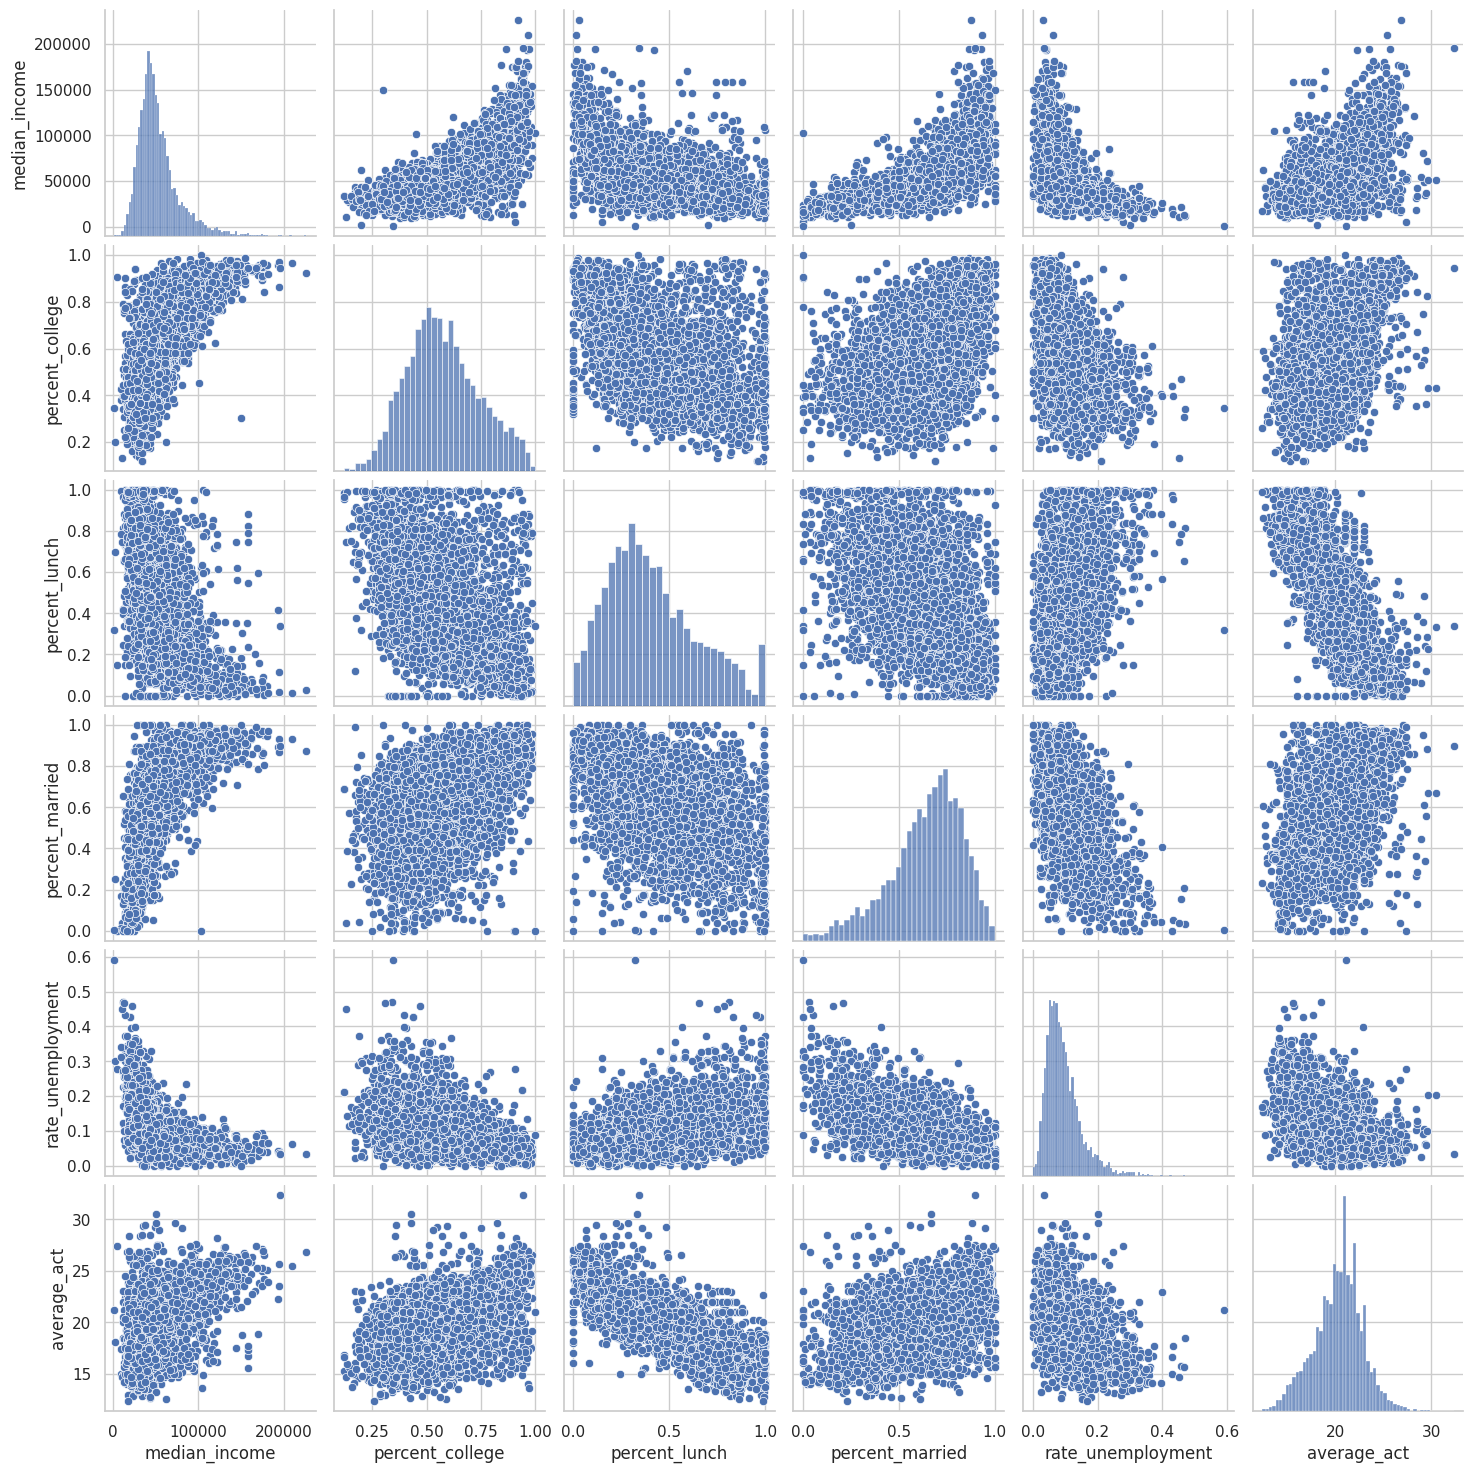

In [ ]:
sns.pairplot(df_train.drop(columns = ['school_level', 'school_type', 'year', 'zip_code']))

## Correlation Matrix

<ipython-input-4-e91f7af7ac0e>:1: FutureWarning:

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.



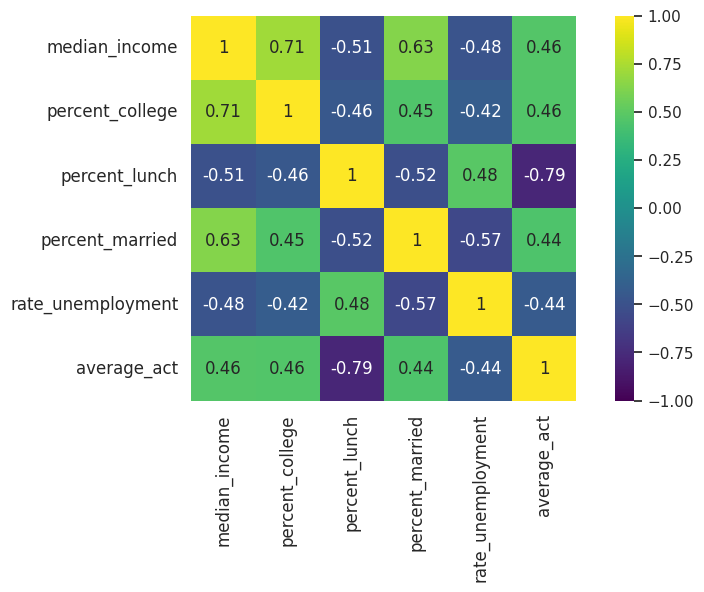

In [ ]:
corr_matrix = df_train.drop(columns = ['school_level', 'school_type', 'year', 'zip_code']).corr() 

plt.figure(figsize=(10,5))

sns.heatmap(corr_matrix, vmax=1, vmin=-1, square=True, annot=True, cmap='viridis')

plt.tick_params(labelsize=12);

## Model Fits

### create a model fit for all predictors

In [ ]:
model = smf.ols(formula='average_act ~ median_income + rate_unemployment + percent_lunch + percent_married + percent_college', data = df_train).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:            average_act   R-squared:                       0.632
Model:                            OLS   Adj. R-squared:                  0.632
Method:                 Least Squares   F-statistic:                     1985.
Date:                Fri, 05 May 2023   Prob (F-statistic):               0.00
Time:                        21:09:10   Log-Likelihood:                -10654.
No. Observations:                5781   AIC:                         2.132e+04
Df Residuals:                    5775   BIC:                         2.136e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            22.7774      0.15

the p-values for `percent_married` and `median_income` are not relevant or important in this context, with all the variables together. When all 5 variables are together, just `rate_unemployment`, `percent_lunch`, and `percent_college` are really relevant.

Compare each model with other models with the same number of variables. Best subset selection code

In [ ]:
models = {}
summaries  = {}

combinations = list(it.combinations(df_train.columns[1:], 2))



### Model fit with Regression Line - Median Income and Average ACT Score

Make a scatter plot with a regression line for `median_income` and `average_act`

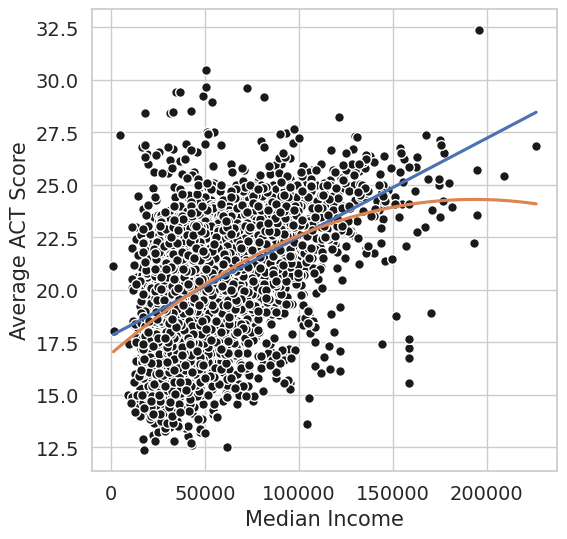

In [ ]:
plt.figure(figsize=(6,6))

# Scatter plot 
plt.plot(df_train['median_income'], df_train['average_act'], 'ko', mec ='w', ms=7)

# Add the regression line
sns.regplot(data=df_train, x = 'median_income', y = 'average_act', order=1, scatter=False, ci=None)
sns.regplot(data=df_train, x = 'median_income', y = 'average_act', order=2, scatter=False, ci=None)

# Add axis labels
plt.xlabel('Median Income', fontsize=15)
plt.ylabel('Average ACT Score', fontsize=15)

# Increase the fontsize of the tick labels
plt.tick_params(labelsize=14);

In [ ]:
median_income_model = smf.ols(formula='average_act ~ median_income', data = df_train).fit()

print(median_income_model.summary())

                            OLS Regression Results                            
Dep. Variable:            average_act   R-squared:                       0.215
Model:                            OLS   Adj. R-squared:                  0.215
Method:                 Least Squares   F-statistic:                     1581.
Date:                Fri, 05 May 2023   Prob (F-statistic):          6.93e-306
Time:                        21:09:11   Log-Likelihood:                -12846.
No. Observations:                5781   AIC:                         2.570e+04
Df Residuals:                    5779   BIC:                         2.571e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        17.8147      0.069    256.723

### Model fit with Regression Line - Percent of Students of Assisted Lunch and Average ACT Score

Make a scatter plot with a regression line for `percent_lunch` and `average_act`

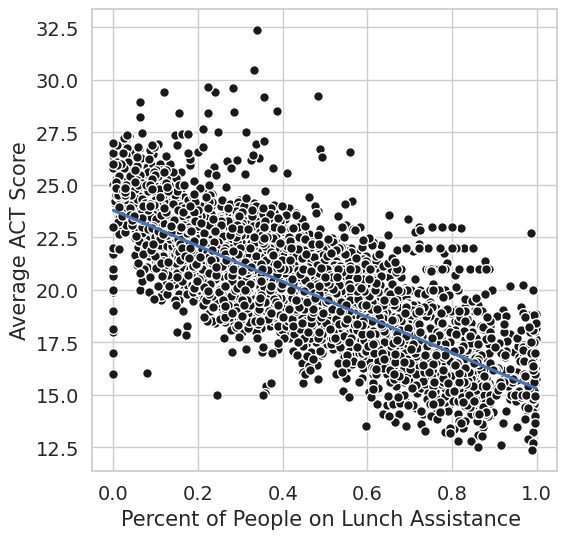

In [ ]:
plt.figure(figsize=(6,6))

# Scatter plot 
plt.plot(df_train['percent_lunch'], df_train['average_act'], 'ko', mec ='w', ms=7)

# Add the regression line
sns.regplot(data=df_train, x = 'percent_lunch', y = 'average_act', order=1, scatter=False, ci=None)

# Add axis labels
plt.xlabel('Percent of People on Lunch Assistance ', fontsize=15)
plt.ylabel('Average ACT Score', fontsize=15)

# Increase the fontsize of the tick labels
plt.tick_params(labelsize=14);

`percent_lunch` model

In [ ]:
percent_lunch_model = smf.ols(formula='average_act ~ percent_lunch', data = df_train).fit()

print(percent_lunch_model.summary())

                            OLS Regression Results                            
Dep. Variable:            average_act   R-squared:                       0.619
Model:                            OLS   Adj. R-squared:                  0.619
Method:                 Least Squares   F-statistic:                     9407.
Date:                Fri, 05 May 2023   Prob (F-statistic):               0.00
Time:                        21:09:11   Log-Likelihood:                -10753.
No. Observations:                5781   AIC:                         2.151e+04
Df Residuals:                    5779   BIC:                         2.152e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        23.7861      0.041    577.051

## Heat Map Visualizations

Where's the data coming from?

In [ ]:
layout = dict(geo={'scope': 'usa'})

data = dict(type='choropleth',
            locations=df_train['state'].unique(),
            locationmode='USA-states',
            z=np.ones(len(df_train['state'].unique())),
            text=df_train['state'].unique())

x = go.Figure(data=[data], layout=layout)

pyo.iplot(x)

ACT Scores by State

In [ ]:
layout = dict(
    geo={'scope': 'usa'},
    title='ACT Scores by State'
)

#Define Data
data = dict(
    type='choropleth',
    locations=df_train['state'],
    locationmode='USA-states',
    z=df_train['average_act'],
    text=df_train['state'],
    colorscale='Viridis',
    colorbar={'title': 'Average ACT Scores'}
)

#Create figure object
fig = go.Figure(data = [data], layout = layout)

#show the figure
pyo.iplot(fig)

Median Income by State

In [ ]:
layout = dict(
    geo={'scope': 'usa'},
    title='Median Income by State'
)

#Define Data
data = dict(
    type='choropleth',
    locations=df_train['state'],
    locationmode='USA-states',
    z=df_train['median_income'],
    text=df_train['state'],
    colorscale='Viridis',
    colorbar={'title': 'Median Income'}
)

#Create figure object
fig2 = go.Figure(data = [data], layout = layout)

#show the figure
pyo.iplot(fig2)

Percent of Students on Assisted Lunch by State

In [ ]:
layout = dict(
    geo={'scope': 'usa'},
    title='Percent of Students on Assisted Lunch by State'
)

#Define Data
data = dict(
    type='choropleth',
    locations=df_train['state'],
    locationmode='USA-states',
    z=df_train['percent_lunch'],
    text=df_train['state'],
    colorscale='Viridis',
    colorbar={'title': 'Percent of Students on Assisted Lunch'}
)

#Create figure object
fig3 = go.Figure(data = [data], layout = layout)

#show the figure
pyo.iplot(fig3)

## Prediction

 predictive model designed to estimate ACT scores.

In [ ]:
y_prediction = model.predict()

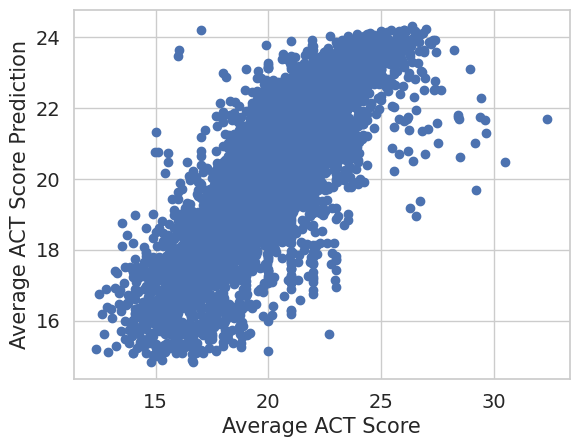

In [ ]:
plt.plot(df_train['average_act'], y_prediction, 'o')

# Add axis labels
plt.xlabel('Average ACT Score', fontsize=15)
plt.ylabel('Average ACT Score Prediction', fontsize=15)

# Increase the fontsize of the tick labels
plt.tick_params(labelsize=14);

In [ ]:
X = df_train[df_train.columns.difference(['id', 'average_act', 'year', 'zip_code', 'school_type', 'school_level', 'state'])]

Y = df_train['average_act']

In [ ]:
variable_names = X.columns.values

variable_names

array(['median_income', 'percent_college', 'percent_lunch',
       'percent_married', 'rate_unemployment'], dtype=object)

In [ ]:
from itertools import combinations
from math import comb

In [ ]:
subset = combinations(variable_names, 2)

for n, names in enumerate(subset):
  print(names)

('median_income', 'percent_college')
('median_income', 'percent_lunch')
('median_income', 'percent_married')
('median_income', 'rate_unemployment')
('percent_college', 'percent_lunch')
('percent_college', 'percent_married')
('percent_college', 'rate_unemployment')
('percent_lunch', 'percent_married')
('percent_lunch', 'rate_unemployment')
('percent_married', 'rate_unemployment')


In [ ]:
names

('percent_married', 'rate_unemployment')

In [ ]:
predictors = X.loc[:,names]

predictors.head()

,percent_married,rate_unemployment
0,0.574034,0.111111
1,0.711429,0.135246
2,0.694514,0.083419
3,0.766901,0.062531
4,0.803435,0.071429


In [ ]:
model = sm.OLS(Y, sm.add_constant(predictors)).fit() 

In [ ]:
model.rsquared_adj

0.24585279358667755

In [ ]:
model.aic

25463.147796006127

In [ ]:
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:            average_act   R-squared:                       0.246
Model:                            OLS   Adj. R-squared:                  0.246
Method:                 Least Squares   F-statistic:                     943.1
Date:                Fri, 05 May 2023   Prob (F-statistic):               0.00
Time:                        21:09:13   Log-Likelihood:                -12729.
No. Observations:                5781   AIC:                         2.546e+04
Df Residuals:                    5778   BIC:                         2.548e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                19.0637      0.16

<Figure size 600x600 with 0 Axes>

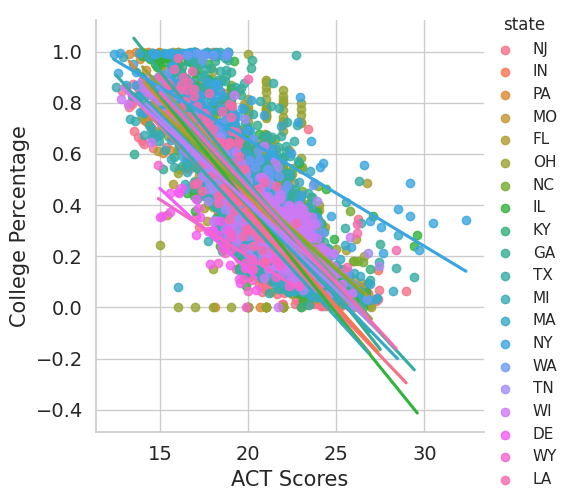

In [ ]:
plt.figure(figsize=(6,6))

# Add the regression lines
sns.lmplot(data= df_train, x = 'average_act', y = 'percent_lunch', hue = 'state', ci=None)

# Add axis labels
plt.xlabel('ACT Scores', fontsize=15)
plt.ylabel('College Percentage', fontsize=15)

# Increase the fontsize of the tick labels
plt.tick_params(labelsize=14);

State Comparisons of Washington and Illinois 

In [29]:
def region_from_states(state): 
  if state in ['WA']:
    return 'washington'
  elif state in ['IL']:
    return 'illinois'
  else:
    return 'other'

In [31]:
df_train['region'] = df_train['state'].apply(region_from_states)

In [32]:
df_train[df_train['region']== 'washington']

,median_income,percent_college,percent_lunch,percent_married,rate_unemployment,school_level,school_type,state,year,zip_code,average_act,region
31,68371.0,0.832136,0.255148,0.525547,0.091684,High,Regular School,WA,2016-2017,98125,23.498168,washington
45,61250.0,0.621197,0.242017,0.661754,0.159808,High,Regular School,WA,2016-2017,98373,21.568987,washington
48,38182.0,0.620830,0.363921,0.615611,0.134357,High,Regular School,WA,2016-2017,98532,22.594628,washington
88,41062.0,0.359717,0.986425,0.731992,0.061127,High,Regular School,WA,2016-2017,98813,18.003663,washington
103,45781.0,0.497257,0.676550,0.560061,0.096353,High,Regular School,WA,2016-2017,98146,18.516484,washington
...,...,...,...,...,...,...,...,...,...,...,...,...
5650,49556.0,0.456219,0.344086,0.640217,0.097105,High,Regular School,WA,2016-2017,98937,19.420024,washington
5683,23438.0,0.627907,0.514218,0.482927,0.110112,High,Regular School,WA,2016-2017,98624,21.739927,washington
5731,37716.0,0.455696,0.372687,0.517602,0.090952,High,Regular School,WA,2016-2017,98233,21.788767,washington
5735,65673.0,0.713380,0.280816,0.659926,0.026611,High,Regular School,WA,2016-2017,98133,22.936508,washington


In [33]:
df_train[df_train['region']== 'illinois']

,median_income,percent_college,percent_lunch,percent_married,rate_unemployment,school_level,school_type,state,year,zip_code,average_act,region
9,66492.000000,0.599102,0.230769,0.881449,0.109262,High,Regular School,IL,2016-2017,61024,19.9,illinois
27,76037.000000,0.611076,0.460407,0.768087,0.104948,High,Regular School,IL,2016-2017,60099,18.4,illinois
61,27596.385705,0.418893,0.889632,0.440392,0.152056,High,Regular School,IL,2016-2017,60615,17.7,illinois
76,65398.000000,0.614004,0.228700,0.679654,0.069004,High,Regular School,IL,2016-2017,62670,21.1,illinois
77,50707.000000,0.286855,0.625973,0.529106,0.140100,High,Regular School,IL,2016-2017,60073,18.0,illinois
...,...,...,...,...,...,...,...,...,...,...,...,...
5742,32500.000000,0.549268,0.550775,0.508100,0.166348,High,Regular School,IL,2016-2017,62896,18.6,illinois
5746,78066.000000,0.863728,0.091057,0.903930,0.101664,High,Regular School,IL,2016-2017,61525,24.8,illinois
5749,46893.000000,0.592249,0.198507,0.755285,0.095931,High,Regular School,IL,2016-2017,61523,20.4,illinois
5767,46844.000000,0.640316,0.308140,0.702945,0.042866,High,Regular School,IL,2016-2017,62449,19.3,illinois


In [35]:
df_states_wanted = df_train[df_train['region'] != 'other']

<Figure size 600x600 with 0 Axes>

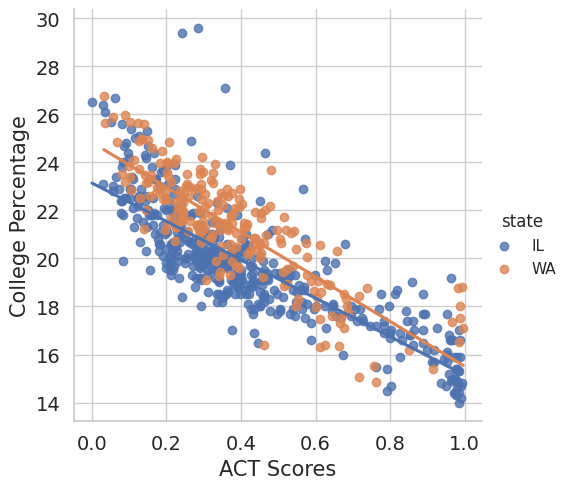

In [38]:
plt.figure(figsize=(6,6))
# Add the regression lines
sns.lmplot(data= df_states_wanted, x = 'percent_lunch', y = 'average_act', hue = 'state', ci=None)

# Add axis labels
plt.xlabel('ACT Scores', fontsize=15)
plt.ylabel('College Percentage', fontsize=15)

# Increase the fontsize of the tick labels
plt.tick_params(labelsize=14);

Here the comparison between Illinois and Washington reveals a striking similarity in terms of the relationship between the strongest socioeconomic factor, the free/reduced price lunch program, and the average ACT scores.

# Conclusion


In conclusion, our project provides conclusive evidence of a robust relationship between ACT/SAT scores and socioeconomic factors. This is evident from the high accuracy (R2) of our predictions, the statistically significant coefficients associated with these factors, and the measure of accuracy expressed in ACT units. These findings highlight the crucial role of socioeconomic factors in shaping test scores and emphasize the significance of addressing educational inequality through targeted interventions.

In conducting this research project, it is important to acknowledge certain limitations that may have impacted our findings. Firstly, we must recognize that we may have missed important predictors, such as whether schools require ACT/SAT test-taking or not. Additionally, the availability of data varied across states, with some states having limited or missing overall data. Furthermore, it is worth noting that the SAT underwent changes in 2016, which could have influenced the results. Another limitation is the reliance on indirect measurements of certain conditions for students. Lastly, quality control issues, such as SAT/ACT conversions, may have introduced uncertainties into the analysis. Despite these limitations, our research provides valuable insights into the relationship between ACT/SAT scores and socioeconomic factors. 